In [16]:
import numpy as np 
import pandas as pd 
from data_processing import generate_vocab, process_data, create_dataloaders 
from model import get_pretrained_emb, EncoderDecoder, EncoderRNN, DecoderRNN, DecoderSimpleRNN, EncoderSimpleRNN, \
    Attention, DecoderAttnRNN, DecoderRNNV2
from train_eval import count_parameters, summarize_results, \
    plot_single_learning_curve, load_experiment_log
from train_eval import train_and_eval_V3 #, tensor2corpus_V2
import importlib
import pickle as pkl 
import torch

In [17]:
# model identification
MODEL_NAME = 'zh-seq2seq-rnn-simple-context'
SRC_LANG = 'zh'
TARG_LANG = 'en'

# data processing params  
SRC_MAX_SENTENCE_LEN = 10
TARG_MAX_SENTENCE_LEN = 10
SRC_VOCAB_SIZE = 30000 #30000
TARG_VOCAB_SIZE = 30000 #30000

# model architecture params 
NUM_LAYERS = 2 #2 
ENC_HIDDEN_DIM = 300 
DEC_HIDDEN_DIM = ENC_HIDDEN_DIM #2 * ENC_HIDDEN_DIM 
TEACHER_FORCING_RATIO = 1
CLIP_GRAD_MAX_NORM = 1
ENC_DROPOUT = 0 # to actually implement
DEC_DROPOUT = 0 # to actually implement

# training params  
BATCH_SIZE = 16 #32
NUM_EPOCHS = 200
LR = 0.0005 # 0.0005
OPTIMIZER = 'Adam'
LAZY_TRAIN = True

In [18]:
# store as dict to save to results later 
params = {'model_name': MODEL_NAME, 'src_lang': SRC_LANG, 'targ_lang': TARG_LANG, 
          'src_max_sentence_len': SRC_MAX_SENTENCE_LEN, 'targ_max_sentence_len': TARG_MAX_SENTENCE_LEN, 
          'src_vocab_size': SRC_VOCAB_SIZE, 'targ_vocab_size': TARG_VOCAB_SIZE, 
          'num_layers': NUM_LAYERS, 'enc_hidden_dim': ENC_HIDDEN_DIM, 'dec_hidden_dim': DEC_HIDDEN_DIM,
          'teacher_forcing_ratio': TEACHER_FORCING_RATIO, 'clip_grad_max_norm': CLIP_GRAD_MAX_NORM,
          'enc_dropout': ENC_DROPOUT, 'dec_dropout': DEC_DROPOUT, 
          'batch_size': BATCH_SIZE, 'num_epochs': NUM_EPOCHS, 'learning_rate': LR, 'optimizer': OPTIMIZER, 
          'lazy_train': LAZY_TRAIN} 

In [19]:
#vocab_test = generate_vocab(SRC_LANG, TARG_LANG, SRC_VOCAB_SIZE, TARG_VOCAB_SIZE)

In [20]:
#vocab['zh']['id2token'][987]

In [21]:
#vocab['zh']['token2id']['森林']

In [22]:
#vocab['en']['token2id']['activity']

In [23]:
#vocab['en']['id2token'][987]

In [24]:
# # takes a long time to process, save to pickle for reimport in future 
# vocab = generate_vocab(SRC_LANG, TARG_LANG, SRC_VOCAB_SIZE, TARG_VOCAB_SIZE)
# vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
# pkl.dump(vocab, open(vocab_filename, "wb"))

In [25]:
# reload from pickle 
vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
vocab = pkl.load(open(vocab_filename, "rb"))
data = process_data(SRC_LANG, TARG_LANG, vocab)
data_minibatch = process_data(SRC_LANG, TARG_LANG, vocab, sample_limit=BATCH_SIZE) 
data_minitrain = process_data(SRC_LANG, TARG_LANG, vocab, sample_limit=1000)

In [26]:
# # takes a long time to process, save to pickle for reimport in future 
# vocab = generate_vocab(SRC_LANG, TARG_LANG, SRC_VOCAB_SIZE, TARG_VOCAB_SIZE)
# vocab_filename = "{}-{}-vocab-fake.p".format(SRC_LANG, TARG_LANG)
# pkl.dump(vocab, open(vocab_filename, "wb"))

In [27]:
# vocab_filename = "{}-{}-vocab-fake.p".format(SRC_LANG, TARG_LANG)
# vocab = pkl.load(open(vocab_filename, "rb"))
# data = process_data(SRC_LANG, TARG_LANG, vocab)
# limited_data = process_data(SRC_LANG, TARG_LANG, vocab, sample_limit=BATCH_SIZE) 

In [28]:
# create dataloaders 
loaders_full = create_dataloaders(data, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minibatch = create_dataloaders(data_minibatch, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minitrain = create_dataloaders(data_minitrain, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)

In [29]:
# define model 

# encoder = EncoderRNN(enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, src_max_sentence_len=SRC_MAX_SENTENCE_LEN,
#                      pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))
encoder = EncoderSimpleRNN(enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, src_max_sentence_len=SRC_MAX_SENTENCE_LEN,
                           pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))

# decoder = DecoderRNNV2(dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
#                        targ_vocab_size=TARG_VOCAB_SIZE, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
#                        pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
# decoder = DecoderSimpleRNN(dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
#                            targ_vocab_size=TARG_VOCAB_SIZE, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
#                            pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
decoder = DecoderAttnRNN(dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
                         targ_vocab_size=TARG_VOCAB_SIZE, src_max_sentence_len=SRC_MAX_SENTENCE_LEN, 
                         targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
                         pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))

model = EncoderDecoder(encoder, decoder, vocab[TARG_LANG]['token2id']) 

In [31]:
model, results = train_and_eval_V3(
    model=model, loaders_full=loaders_full, loaders_minibatch=loaders_minibatch, loaders_minitrain=loaders_minitrain, 
    params=params, vocab=vocab, print_intermediate=True, save_checkpoint=True, save_to_log=True, 
    lazy_eval=False, inspect_samples=1)

Epoch: 0.00, Train Loss: 7.97, Val Loss: 9.81, Train BLEU: 0.36, Val BLEU: 0.22
Sampling from training predictions...
Source: 当 你 站 在 海滩 上 或是 当 你 看到
Reference: part of the problem , i think , is
Model: <SOS> the the the the the the the the the

Sampling from val predictions...
Source: 我们 每天 要 走 不同 的 路线 这样 才 没有
Reference: each day , we took a different route so
Model: <SOS> the the the the the the the the the

Epoch: 1.00, Train Loss: 7.44, Val Loss: 9.71, Train BLEU: 0.36, Val BLEU: 0.22
Sampling from training predictions...
Source: 其实 实地 地球 上 最长 的 山脉 都 在 海洋
Reference: and in the oceans , there are the longest
Model: <SOS> the the the the the the the the the

Sampling from val predictions...
Source: 这 是 我们 俩 人 唯一 的 受教 教育 方式
Reference: it was the only way we both could be
Model: <SOS> the the the the the the the the the

Epoch: 2.00, Train Loss: 6.97, Val Loss: 9.65, Train BLEU: 0.36, Val BLEU: 0.22
Sampling from training predictions...
Source: 当 你 站 在 海滩 上 或是 当 你 看到
Reference: part of 

Epoch: 19.00, Train Loss: 3.55, Val Loss: 10.84, Train BLEU: 0.47, Val BLEU: 0.22
Sampling from training predictions...
Source: 大卫 <UNK> 这位 是 比尔 <UNK> 我 是 大卫 <UNK>
Reference: this is bill lange . i &apos;m dave gallo
Model: <SOS> most the the is is is is is is

Sampling from val predictions...
Source: 我 永远 不会 忘记 那个 早晨 <EOS> <PAD> <PAD> <PAD>
Reference: a morning that i will never forget . <EOS>
Model: <SOS> most the the the the the the the the

Epoch: 20.00, Train Loss: 3.51, Val Loss: 10.96, Train BLEU: 0.47, Val BLEU: 0.22
Sampling from training predictions...
Source: 我们 将 用 一些 影片 来讲 讲述 一些 深海 海里
Reference: and we &apos;re going to tell you some stories
Model: <SOS> most the the the the the the the the

Sampling from val predictions...
Source: 我 6 岁 那年 塔利 塔利班 占领 阿富汗 并 规定
Reference: you see , i was six when the taliban
Model: <SOS> most the the the the the the the the

Epoch: 21.00, Train Loss: 3.47, Val Loss: 11.07, Train BLEU: 0.47, Val BLEU: 0.22
Sampling from training predictions..

Epoch: 38.00, Train Loss: 2.89, Val Loss: 12.02, Train BLEU: 0.72, Val BLEU: 0.27
Sampling from training predictions...
Source: 其实 实地 地球 上 最长 的 山脉 都 在 海洋
Reference: and in the oceans , there are the longest
Model: <SOS> most the the the the the the the ,

Sampling from val predictions...
Source: 我们 都 知道 自己 正 冒 着 生命 的 危险
Reference: we all knew we were risking our lives --
Model: <SOS> most the the the the the the the ,

Epoch: 39.00, Train Loss: 2.86, Val Loss: 12.07, Train BLEU: 1.13, Val BLEU: 0.24
Sampling from training predictions...
Source: 大多 大多数 多数 地震 和 火山 喷发 也 都 发生
Reference: most of the earthquakes and volcanoes are in the
Model: <SOS> most of the the the the the the the

Sampling from val predictions...
Source: 我 11 岁 那年 记得 得有 一天 早晨 醒来 听见
Reference: when i was 11 , i remember waking up
Model: <SOS> most the the the the the the the the

Epoch: 40.00, Train Loss: 2.82, Val Loss: 12.11, Train BLEU: 1.12, Val BLEU: 0.23
Sampling from training predictions...
Source: 这儿 基本 基本上 都 没有 

Epoch: 57.00, Train Loss: 2.22, Val Loss: 12.47, Train BLEU: 11.11, Val BLEU: 0.28
Sampling from training predictions...
Source: 大卫 <UNK> 通过 潜水 潜水艇 拍下 的 影片 把 我们
Reference: with vibrant video clips captured by submarines , david
Model: <SOS> with vibrant video video video david david david david

Sampling from val predictions...
Source: 我 6 岁 那年 塔利 塔利班 占领 阿富汗 并 规定
Reference: you see , i was six when the taliban
Model: <SOS> the of the the the the the the the

Epoch: 58.00, Train Loss: 2.18, Val Loss: 12.48, Train BLEU: 10.81, Val BLEU: 0.28
Sampling from training predictions...
Source: 原因 在于 我们 一直 没 把 海洋 当回事 回事 回事儿
Reference: and the problem , i think , is that
Model: <SOS> and the problem , , , , , ,

Sampling from val predictions...
Source: 这 是 我们 俩 人 唯一 的 受教 教育 方式
Reference: it was the only way we both could be
Model: <SOS> most of the the the the , , ,

Epoch: 59.00, Train Loss: 2.15, Val Loss: 12.50, Train BLEU: 10.89, Val BLEU: 0.28
Sampling from training predictions...
Source: 这儿

Epoch: 76.00, Train Loss: 1.57, Val Loss: 12.79, Train BLEU: 29.11, Val BLEU: 0.30
Sampling from training predictions...
Source: 地球 的 大部 大部分 部分 都 是 海水 <EOS> <PAD>
Reference: most of the planet is ocean water . <EOS>
Model: <SOS> most of the planet is ocean . . .

Sampling from val predictions...
Source: 我 6 岁 那年 塔利 塔利班 占领 阿富汗 并 规定
Reference: you see , i was six when the taliban
Model: <SOS> the of the the the the is is is

Epoch: 77.00, Train Loss: 1.53, Val Loss: 12.81, Train BLEU: 31.57, Val BLEU: 0.30
Sampling from training predictions...
Source: 我们 将 用 一些 影片 来讲 讲述 一些 深海 海里
Reference: and we &apos;re going to tell you some stories
Model: <SOS> and we and and and , , are are

Sampling from val predictions...
Source: 冬天 很 舒服 但 夏天 却 <UNK> <EOS> <PAD> <PAD>
Reference: it was cozy in winter but extremely hot in
Model: <SOS> life in the deep oceans <EOS> <EOS> <EOS> <EOS>

Epoch: 78.00, Train Loss: 1.50, Val Loss: 12.83, Train BLEU: 35.96, Val BLEU: 0.30
Sampling from training predictions

Epoch: 95.00, Train Loss: 1.04, Val Loss: 13.15, Train BLEU: 64.41, Val BLEU: 0.61
Sampling from training predictions...
Source: 大卫 <UNK> 通过 潜水 潜水艇 拍下 的 影片 把 我们
Reference: with vibrant video clips captured by submarines , david
Model: <SOS> with vibrant video clips captured by submarines submarines david

Sampling from val predictions...
Source: 你 现在 可以 去 个 真正 的 学校 念书 了
Reference: &quot; you can go to a real school now
Model: <SOS> and &apos;s the the , , , , are

Epoch: 96.00, Train Loss: 1.01, Val Loss: 13.18, Train BLEU: 67.95, Val BLEU: 0.62
Sampling from training predictions...
Source: 泰坦 泰坦尼克 泰坦尼克号 坦尼 尼克 号 是 拿 了 不少
Reference: the truth of the matter is that the titanic
Model: <SOS> the truth of the matter is that titanic titanic

Sampling from val predictions...
Source: 学校 在 一个 房屋 房屋里 屋里 我们 100 多 人
Reference: the school was in a house , more than
Model: <SOS> and biodiversity the the <UNK> the the the is

Epoch: 97.00, Train Loss: 0.99, Val Loss: 13.16, Train BLEU: 68.44, Val BLE

Epoch: 114.00, Train Loss: 0.69, Val Loss: 13.42, Train BLEU: 90.96, Val BLEU: 0.58
Sampling from training predictions...
Source: 大卫 <UNK> 通过 潜水 潜水艇 拍下 的 影片 把 我们
Reference: with vibrant video clips captured by submarines , david
Model: <SOS> with vibrant video clips captured by submarines , david

Sampling from val predictions...
Source: 学校 在 一个 房屋 房屋里 屋里 我们 100 多 人
Reference: the school was in a house , more than
Model: <SOS> the biodiversity and the and the the is is

Epoch: 115.00, Train Loss: 0.67, Val Loss: 13.43, Train BLEU: 88.32, Val BLEU: 0.58
Sampling from training predictions...
Source: 我们 这 有 不少 精彩 的 泰坦 泰坦尼克 坦尼 尼克
Reference: we &apos;ve got some of the most incredible video
Model: <SOS> we &apos;ve got some of the most incredible video

Sampling from val predictions...
Source: 我们 每天 要 走 不同 的 路线 这样 才 没有
Reference: each day , we took a different route so
Model: <SOS> part of the problem , , , , is

Epoch: 116.00, Train Loss: 0.66, Val Loss: 13.45, Train BLEU: 90.96, Val BLEU:

Epoch: 132.00, Train Loss: 0.45, Val Loss: 13.52, Train BLEU: 98.44, Val BLEU: 0.58
Sampling from training predictions...
Source: 原因 在于 我们 一直 没 把 海洋 当回事 回事 回事儿
Reference: and the problem , i think , is that
Model: <SOS> and the problem , i think , is that

Sampling from val predictions...
Source: 我们 都 知道 自己 正 冒 着 生命 的 危险
Reference: we all knew we were risking our lives --
Model: <SOS> and of the the , , , the the

Epoch: 133.00, Train Loss: 0.44, Val Loss: 13.54, Train BLEU: 98.44, Val BLEU: 0.57
Sampling from training predictions...
Source: 原因 在于 我们 一直 没 把 海洋 当回事 回事 回事儿
Reference: and the problem , i think , is that
Model: <SOS> and the problem , i think , is that

Sampling from val predictions...
Source: 我 永远 不会 忘记 那个 早晨 <EOS> <PAD> <PAD> <PAD>
Reference: a morning that i will never forget . <EOS>
Model: <SOS> most of the planet is is water <EOS> <EOS>

Epoch: 134.00, Train Loss: 0.42, Val Loss: 13.55, Train BLEU: 100.00, Val BLEU: 0.58
Sampling from training predictions...
Source: 地

Epoch: 151.00, Train Loss: 0.26, Val Loss: 13.71, Train BLEU: 100.00, Val BLEU: 0.60
Sampling from training predictions...
Source: 大部 大部分 部分 的 动物 也 都 生活 在 海洋
Reference: most of the animals are in the oceans .
Model: <SOS> most of the animals are in the oceans .

Sampling from val predictions...
Source: 我们 把 书 放在 食品 杂货 袋中 这样 别人 就
Reference: we would cover our books in grocery bags so
Model: <SOS> and &apos;s mostly and and , , are are

Epoch: 152.00, Train Loss: 0.26, Val Loss: 13.72, Train BLEU: 100.00, Val BLEU: 0.60
Sampling from training predictions...
Source: 海洋 的 平均 深度 是 两英里 英里 <EOS> <PAD> <PAD>
Reference: the average depth is about two miles . <EOS>
Model: <SOS> the average depth is about two miles . <EOS>

Sampling from val predictions...
Source: 我 的 父亲 在 用 他 的 灰色 小 收音
Reference: my father was listening to bbc news on his
Model: <SOS> part of the the , , , , is

Epoch: 153.00, Train Loss: 0.25, Val Loss: 13.72, Train BLEU: 100.00, Val BLEU: 0.60
Sampling from training prediction

Epoch: 170.00, Train Loss: 0.16, Val Loss: 13.83, Train BLEU: 100.00, Val BLEU: 0.61
Sampling from training predictions...
Source: 其实 实地 地球 上 最长 的 山脉 都 在 海洋
Reference: and in the oceans , there are the longest
Model: <SOS> and in the oceans , there are the longest

Sampling from val predictions...
Source: 我们 把 书 放在 食品 杂货 袋中 这样 别人 就
Reference: we would cover our books in grocery bags so
Model: <SOS> and we &apos;re and and , there you some

Epoch: 171.00, Train Loss: 0.15, Val Loss: 13.85, Train BLEU: 100.00, Val BLEU: 0.61
Sampling from training predictions...
Source: 其实 实地 地球 上 最长 的 山脉 都 在 海洋
Reference: and in the oceans , there are the longest
Model: <SOS> and in the oceans , there are the longest

Sampling from val predictions...
Source: 我 永远 不会 忘记 那个 早晨 <EOS> <PAD> <PAD> <PAD>
Reference: a morning that i will never forget . <EOS>
Model: <SOS> most of the planet is water . <EOS> <EOS>

Epoch: 172.00, Train Loss: 0.15, Val Loss: 13.86, Train BLEU: 100.00, Val BLEU: 0.61
Sampling from

Epoch: 189.00, Train Loss: 0.10, Val Loss: 13.98, Train BLEU: 100.00, Val BLEU: 0.63
Sampling from training predictions...
Source: 地球 的 大部 大部分 部分 都 是 海水 <EOS> <PAD>
Reference: most of the planet is ocean water . <EOS>
Model: <SOS> most of the planet is ocean water . <EOS>

Sampling from val predictions...
Source: 我们 每天 要 走 不同 的 路线 这样 才 没有
Reference: each day , we took a different route so
Model: <SOS> part of the problem , , i , is

Epoch: 190.00, Train Loss: 0.10, Val Loss: 13.99, Train BLEU: 100.00, Val BLEU: 0.63
Sampling from training predictions...
Source: 原因 在于 我们 一直 没 把 海洋 当回事 回事 回事儿
Reference: and the problem , i think , is that
Model: <SOS> and the problem , i think , is that

Sampling from val predictions...
Source: 学校 在 一个 房屋 房屋里 屋里 我们 100 多 人
Reference: the school was in a house , more than
Model: <SOS> the biodiversity and the <UNK> <UNK> are is the

Epoch: 191.00, Train Loss: 0.09, Val Loss: 14.00, Train BLEU: 100.00, Val BLEU: 0.63
Sampling from training predictions...
S

In [32]:
summarize_results(load_experiment_log())[['dt_created', 'num_epochs', 'learning_rate', 'clip_grad_max_norm', 'val_loss']].head()

,dt_created,num_epochs,learning_rate,clip_grad_max_norm,val_loss
57,2018-12-03 19:12:59,200,0.0005,1.0,9.430918
56,2018-12-02 16:49:33,5,0.0005,1.0,10.087201
55,2018-12-02 16:27:14,200,0.0005,1.0,8.701958
54,2018-12-02 16:05:55,200,0.0005,1.0,10.088377
53,2018-12-02 15:57:31,200,0.0005,1.0,10.341496


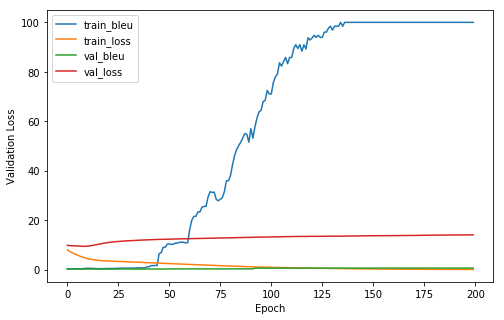

In [33]:
plot_single_learning_curve(results)

In [ ]:
for i, token in enumerate(vocab[SRC_LANG]['id2token']): 
    if i < 20: 
        print("{}: {}".format(i, token))

In [ ]:
for i, token in enumerate(vocab[TARG_LANG]['id2token']): 
    if i < 20: 
        print("{}: {}".format(i, token))

In [ ]:
import torch
x = torch.arange(0, 3*5*10).view(3, 5, 10)
print(x)
y = x[1:, :, :]
print(y)
z = y.view(-1, 10)
print(z)

In [ ]:
t = torch.arange(0, 2*5).view(5, 2)
print(t)
u = t.contiguous().view(-1)
print(u)
v = t.permute(1, 0)
print(v)
w = v.contiguous().view(-1)
print(w)

In [ ]:
a = torch.arange(0, 2*1*300)
print(a)
b = a.view(-1, 1, 300)
print(b.size())

In [ ]:
for i, (src_idxs, targ_idxs, src_lens, targ_lens) in enumerate(full_loaders['train']):
#     print(i)
#     print(src_idxs.size())
#     print(src_idxs)
#     print(src_lens)
#     print(targ_idxs.size())
#     print(targ_idxs)
#     print(targ_lens)
    id2token = vocab[SRC_LANG]['id2token']
    test_tensor = src_idxs
    list_of_lists = test_tensor.numpy().astype(int).tolist()
    to_token = lambda l: ' '.join([id2token[idx] for idx in l])
    list_of_lists_tokens = [to_token(l) for l in list_of_lists] 
    break 